## Importing Required stuff

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile, assemble
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from sympy import Matrix, Rational, sqrt, simplify, init_printing, latex, Abs
from IPython.display import display, Math
from qiskit.quantum_info import Statevector
import math
from scipy.linalg import expm
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.quantum_info import partial_trace
from qiskit.circuit.library import RYGate

## Use the HHL algorithm to solve the 4 × 4 system of linear equations 𝐴𝑥 = 𝑏 given in question 1 (circuit analysis and coding part)

$$
A = \frac{1}{2} \begin{pmatrix}
3 & 0 & 0 & -1 \\
0 & 7 & -1 & 0 \\
0 & -1 & 7 & 0 \\
-1 & 0 & 0 & 3
\end{pmatrix}
$$

$$
B = \frac{1}{\sqrt{2}} \begin{pmatrix}
1 \\
1 \\
0 \\
0
\end{pmatrix}
$$


# a) Calculate the matrix 𝑈 = 𝑒𝑖𝐴𝑡, where 𝐴 is the given matrix (1 pt). (implemented with the circuit)

# b) Encode the vector 𝑏. Specify how you will prepare this state in terms of qubit initialization and any gates required (1 pt).

<IPython.core.display.Latex object>

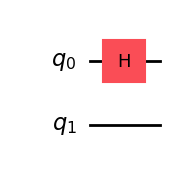

In [2]:
Stateprep = QuantumCircuit(2, name = "State Prep")
#state prep
Stateprep.h(0)
psi  = Statevector(Stateprep)
display(psi.draw("latex"))
display(Stateprep.draw("mpl"))


# c) Implement the HHL circuit with the correct sequence of gates, ensuring proper control and ancilla qubit operations. Implement the Controlled Ry rotation to perform eigenvalue inversion in the HHL algorithm. Provide a circuit diagram (3 pts).

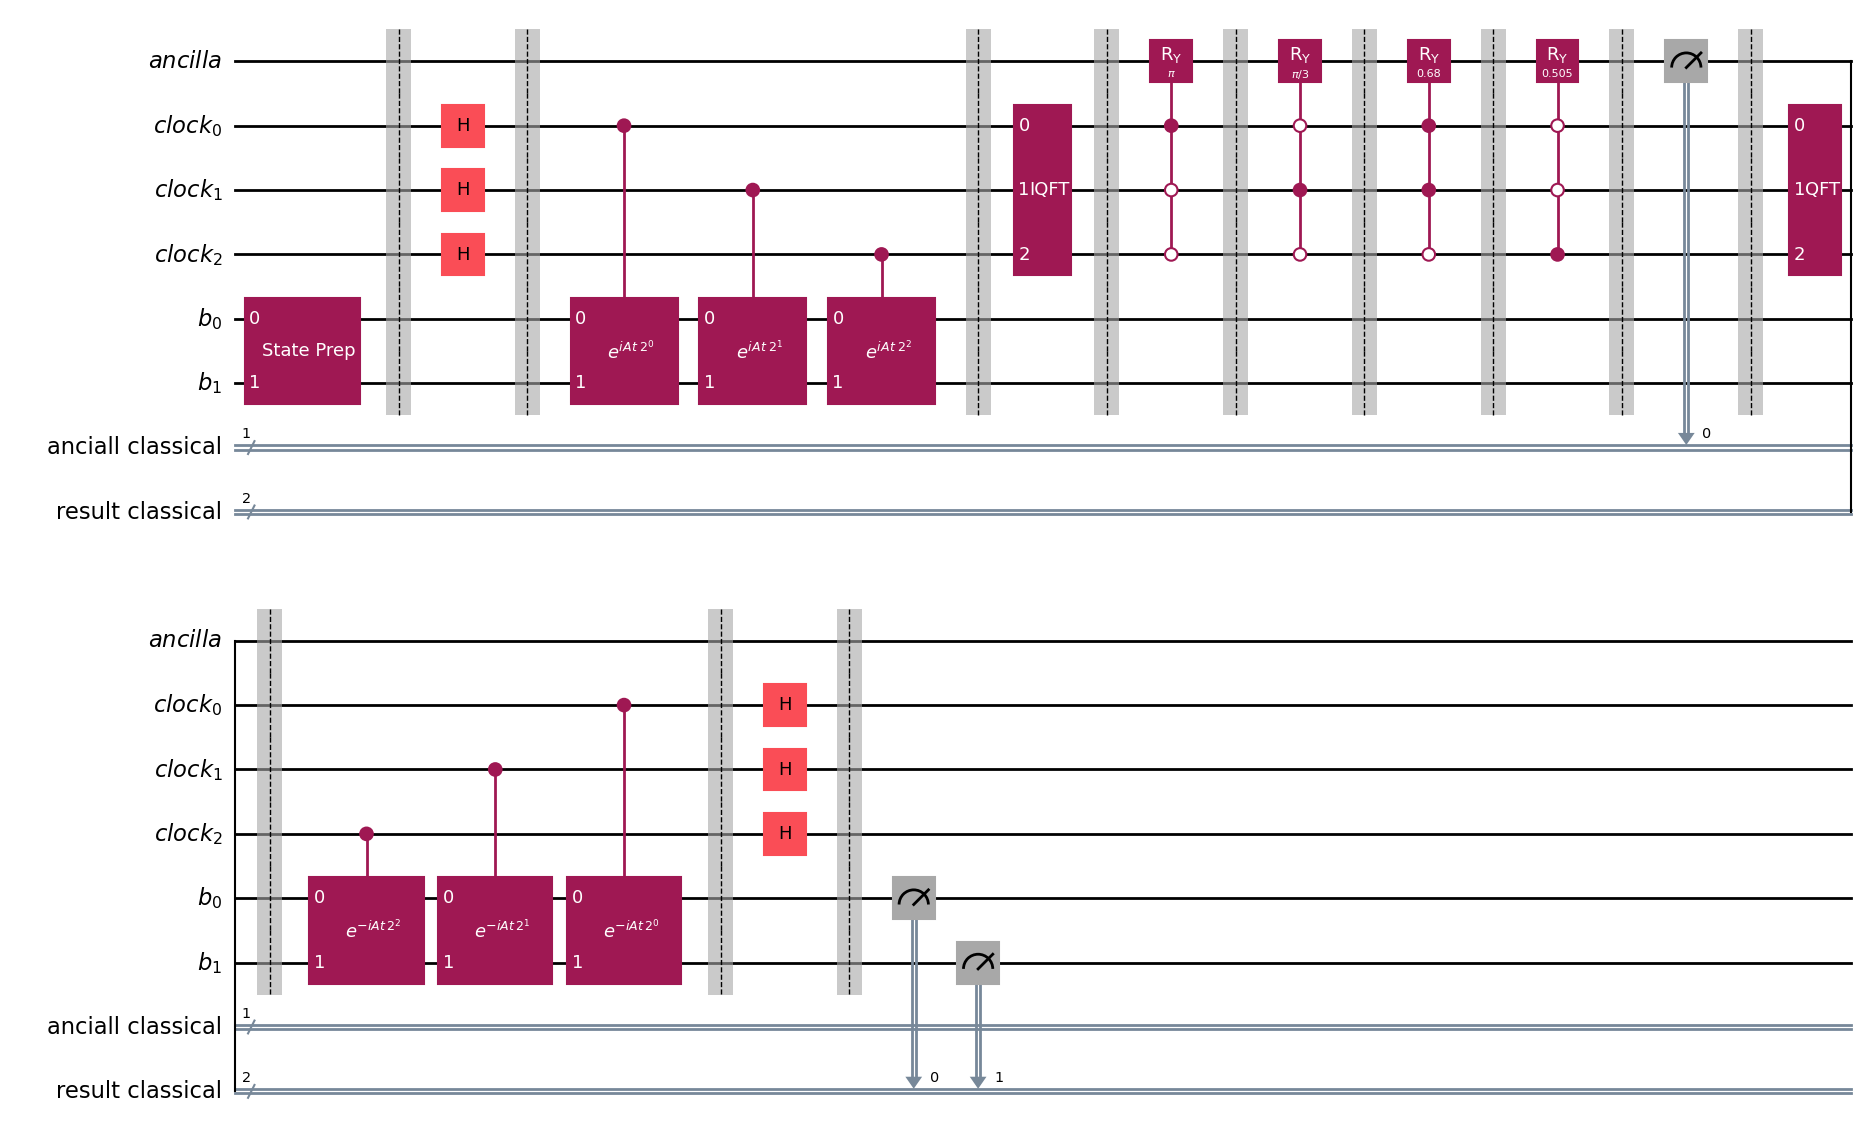

In [3]:
# Create the various registers needed
clock = QuantumRegister(3, name='clock')
b = QuantumRegister(2, name='b')
ancilla = QuantumRegister(1, name='ancilla')
classica_ancialla = ClassicalRegister(1, name = "anciall classical")
classica_results = ClassicalRegister(2, name = "result classical")

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, b, classica_ancialla, classica_results)
circuit.append(Stateprep, b)
circuit.barrier()

circuit.h(clock)
circuit.barrier()

# Define the matrix A
A = (1/2) * np.array([
    [3,   0,   0,  -1],
    [0,   7,  -1,   0],
    [0,  -1,   7,   0],
    [-1,  0,   0,   3]
]) 

t = np.pi / 4

for idx,c in enumerate(clock) : 
    circuit.append(UnitaryGate(expm(1j * A * t * (2**idx) ), label = f"$e^{{i A t \; 2^{idx}}}$").control(num_ctrl_qubits=1) , [c , b[0] , b[1]])
circuit.barrier()

circuit.append(QFT(3, inverse=True), clock)
circuit.barrier()

Rotation1 = QuantumCircuit(4, name = "Ry(θ1)")
theta_1 = 2 * math.asin(1/1.0)
Rotation1.append(RYGate(theta_1).control(3, ctrl_state= "001"), [1, 2, 3, 0])
circuit.append(Rotation1 , range(4))
circuit.barrier()

Rotation2 = QuantumCircuit(4, name = "Ry(θ2)")
theta_2 = 2 * math.asin(1/2.0)
Rotation2.append(RYGate(theta_2).control(3, ctrl_state= "010"), [1, 2, 3, 0])
circuit.append(Rotation2 , range(4))
circuit.barrier()

Rotation3 = QuantumCircuit(4, name = "Ry(θ3)")
theta_3 = 2 * math.asin(1/3.0)
Rotation3.append(RYGate(theta_3).control(3, ctrl_state= "011"), [1, 2, 3, 0])
circuit.append(Rotation3 , range(4))
circuit.barrier()

Rotation4 = QuantumCircuit(4, name = "Ry(θ4)")
theta_4 = 2 * math.asin(1/4.0)
Rotation4.append(RYGate(theta_4).control(3, ctrl_state= "100"), [1, 2, 3, 0])
circuit.append(Rotation4 , range(4))
circuit.barrier()

circuit.measure(ancilla, classica_ancialla)
circuit.barrier()

circuit.append(QFT(3, inverse=False), clock)
circuit.barrier()

for idx, c in enumerate(clock):
    # If you really want a negative i in the exponent:
    Uin = expm((-1j * t) * A * 2**(2 - idx))  # Adjust indexing as needed
    circuit.append(
        UnitaryGate(Uin, label=f"$e^{{-i A t \, 2^{2-idx}}}$").control(num_ctrl_qubits=1),
        [clock[2 - idx], b[0], b[1]]
    )
circuit.barrier()

circuit.h(clock)
circuit.barrier()

circuit.measure(b , classica_results )
gates = ["Ry(θ1)","Ry(θ2)","Ry(θ3)","Ry(θ4)"]
display(circuit.decompose(gates_to_decompose= gates).draw("mpl"))


# d) Interpret the results by showing how the solution to the system of equations is extracted from the circuit output. Explain how measurements provide the values of 𝑥 and compare the quantum solution to the classical solution for validation (2 pts).

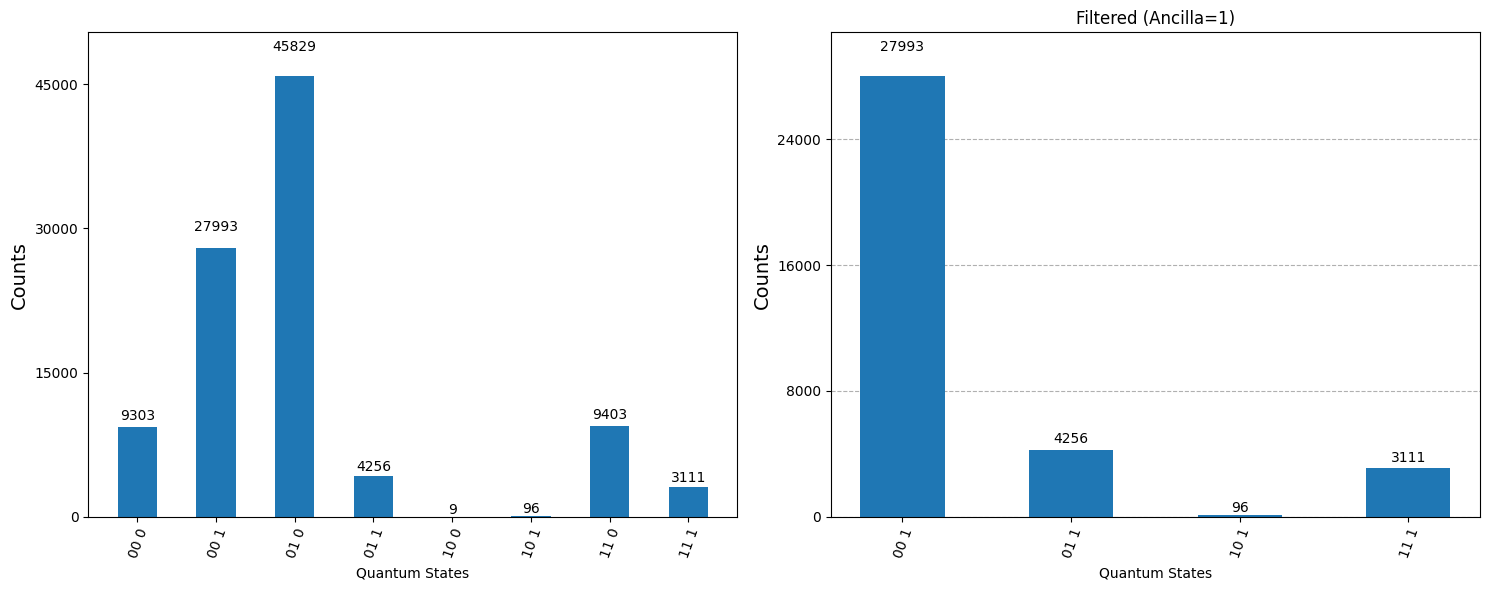

In [4]:
backend = Aer.get_backend('qasm_simulator')
job = backend.run(circuit.decompose(reps=10), shots=100000)
result = job.result()

counts = result.get_counts()
filtered_counts = {state: count for state, count in counts.items() if state[-1] == '1'}


sqrt_total = math.sqrt(sum(filtered_counts.values()))

total_sum = sum(filtered_counts.values())

normalized_amplitudes = {
    state: math.sqrt(count) / math.sqrt(total_sum) for state, count in filtered_counts.items()
}
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: All Results
plot_histogram(counts, ax=axes[0], title="All Results")
axes[0].set_xlabel("Quantum States")
axes[0].set_ylabel("Counts")

# Plot 2: Filtered Counts (Ancilla=1)
plot_histogram(filtered_counts, ax=axes[1], title="Filtered (Ancilla=1)")
axes[1].set_xlabel("Quantum States")
axes[1].set_ylabel("Counts")

# Enhance layout
plt.tight_layout()
plt.show()


In [5]:
B = np.array([1/np.sqrt(2), 1/np.sqrt(2), 0, 0])
solution = np.linalg.solve(A, B)
norm_solution = solution / np.linalg.norm(solution)
print("Normalized solution vector x using Classical Method:", norm_solution)


Normalized solution vector x using Classical Method: [0.88895664 0.34570536 0.04938648 0.29631888]


### Matrix \( A \) and Vector \( B \) and Vector \( x \) Classical solution 

$$
A = \frac{1}{2} \begin{pmatrix}
3 & 0 & 0 & -1 \\
0 & 7 & -1 & 0 \\
0 & -1 & 7 & 0 \\
-1 & 0 & 0 & 3
\end{pmatrix}
$$

$$
B = \frac{1}{\sqrt{2}} \begin{pmatrix}
1 \\
1 \\
0 \\
0
\end{pmatrix}
$$

$$
x =  \begin{pmatrix}
0.8889 \\
0.3457 \\
0.0493 \\
0.2963
\end{pmatrix}
$$


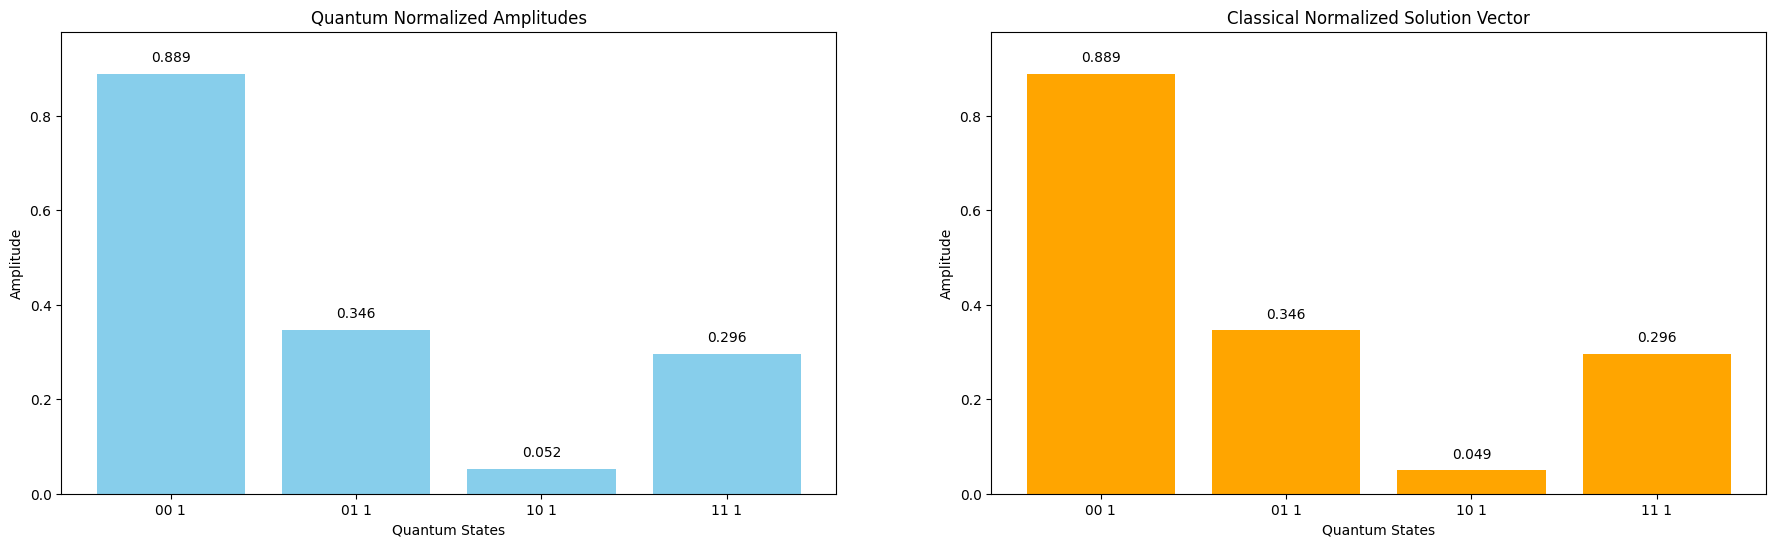

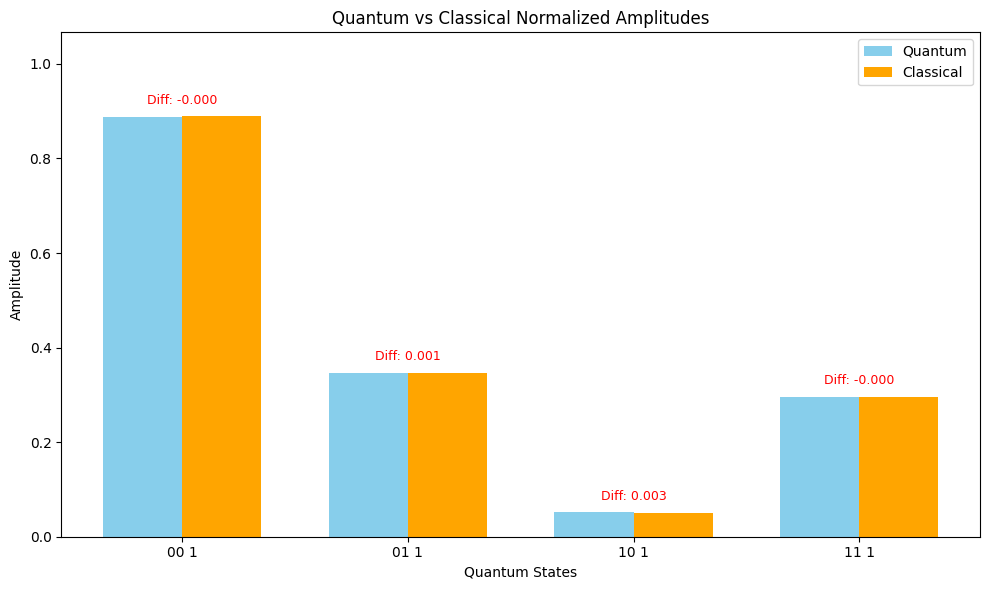

In [6]:
# Plot 3: Normalized Amplitudes using a bar chart
states = sorted(list(normalized_amplitudes.keys()))
# Get quantum amplitudes in sorted order
amplitudes = [normalized_amplitudes[state] for state in states]


classical_amplitudes = norm_solution[:len(states)]
# -------------------- Plotting Side by Side with Difference --------------------
fig, axes = plt.subplots(1, 2, figsize=(22, 6))

# Plot 1: Quantum Normalized Amplitudes
axes[0].bar(states, amplitudes, color='skyblue')
axes[0].set_title("Quantum Normalized Amplitudes")
axes[0].set_xlabel("Quantum States")
axes[0].set_ylabel("Amplitude")
axes[0].set_ylim(0, max(amplitudes + list(classical_amplitudes)) * 1.1)  # Unified y-axis

# Add amplitude labels on top of each bar for Quantum
for i, amplitude in enumerate(amplitudes):
    axes[0].text(i, amplitude + 0.02, f"{amplitude:.3f}", ha='center', va='bottom')

# Plot 2: Classical Normalized Solution
axes[1].bar(states, classical_amplitudes, color='orange')
axes[1].set_title("Classical Normalized Solution Vector")
axes[1].set_xlabel("Quantum States")
axes[1].set_ylabel("Amplitude")
axes[1].set_ylim(0, max(amplitudes + list(classical_amplitudes)) * 1.1)  # Unified y-axis

# Add amplitude labels on top of each bar for Classical
for i, amplitude in enumerate(classical_amplitudes):
    axes[1].text(i, amplitude + 0.02, f"{amplitude:.3f}", ha='center', va='bottom')

# Plot 3: Normalized Amplitudes using a bar chart
states = sorted(list(normalized_amplitudes.keys()))
# Get quantum amplitudes in sorted order
amplitudes = [normalized_amplitudes[state] for state in states]


classical_amplitudes = norm_solution[:len(states)]
# -------------------- Compute Differences --------------------
differences = [q - c for q, c in zip(amplitudes, classical_amplitudes)]

# -------------------- Plotting Side by Side --------------------
x = np.arange(len(states))  # Label locations
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Quantum Amplitudes
bars1 = ax.bar(x - bar_width/2, amplitudes, bar_width, label='Quantum', color='skyblue')

# Plot Classical Amplitudes
bars2 = ax.bar(x + bar_width/2, classical_amplitudes, bar_width, label='Classical', color='orange')

# Add Labels and Title
ax.set_xlabel('Quantum States')
ax.set_ylabel('Amplitude')
ax.set_title('Quantum vs Classical Normalized Amplitudes')
ax.set_xticks(x)
ax.set_xticklabels(states)
ax.legend()

# Add Difference Labels Above the Bars
for i in range(len(states)):
    diff = differences[i]
    # Position for the difference label (centered between the two bars)
    ax.text(x[i], max(amplitudes[i], classical_amplitudes[i]) + 0.02,
            f'Diff: {diff:.3f}', ha='center', va='bottom', fontsize=9, color='red')

# Adjust Y-axis Limit to Make Space for Labels
ax.set_ylim(0, max(max(amplitudes), max(classical_amplitudes)) * 1.2)

# Display the Plot
plt.tight_layout()
plt.show()

# As We can see the the diffrence is very minimal with 100000 tries